In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia = Table.read('../data/gaia_slim.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
G_max_spz = 20.5
save_tag = ''
#save_tag = '_lr0.005'
fn_spz = f'../data/redshifts_spz_ANN_G{G_max_spz}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [5]:
tab_gaia = astropy.table.join(tab_gaia, tab_spz, keys='source_id', join_type='left')

In [6]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

1104830

In [7]:
idx_withsdss = np.isfinite(tab_gaia['redshift_sdss'])
np.sum(idx_withsdss)

260114

In [8]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

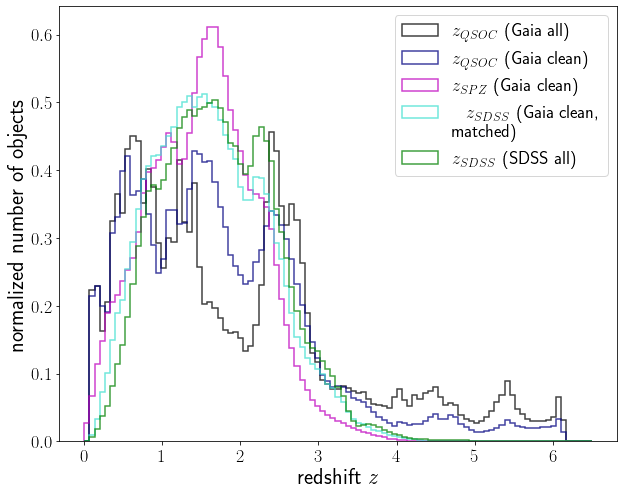

In [9]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

plt.figure(figsize=(10,8))
_ = plt.hist(tab_gaia['redshift_qsoc'], bins=z_bins, alpha=alpha, color='k', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia all)')
_ = plt.hist(tab_gaia['redshift_qsoc'][idx_withspz], bins=z_bins, alpha=alpha, color='navy', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia clean)')
_ = plt.hist(tab_gaia['redshift_spz'], bins=z_bins, alpha=alpha, color='m', lw=lw, 
             density=density, histtype=histtype, label=r'$z_{SPZ}$ (Gaia clean)')
_ = plt.hist(tab_gaia['redshift_sdss'], bins=z_bins, alpha=alpha, color='turquoise', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (Gaia clean,\\matched)')
_ = plt.hist(tab_sdss['Z'], bins=z_bins, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (SDSS all)')
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

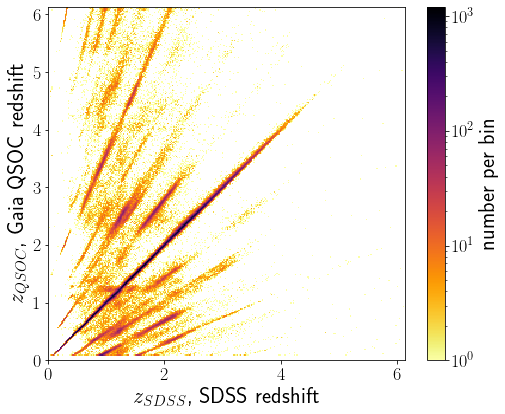

In [10]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

In [27]:
def get_fraction_recovered(Y_true, Y_hat, z_err_close):
    return np.sum(np.abs(Y_true - Y_hat) < z_err_close) / len(Y_true)

def mse(Y_true, Y_hat):
    return np.mean((Y_true - Y_hat)**2, axis=0)

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

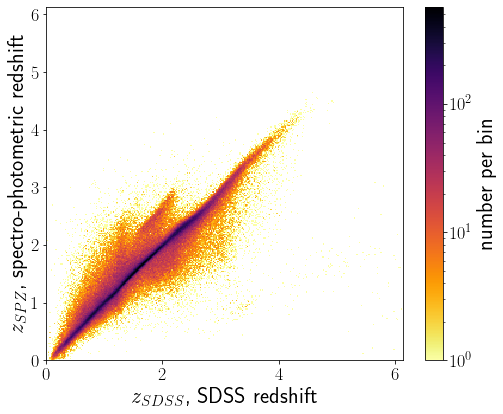

In [12]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['redshift_sdss'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [30]:
mse_spz = mse(tab_gaia['redshift_sdss'][idx_withsdss], tab_gaia['redshift_spz'][idx_withsdss])
mse_baseline = mse(tab_gaia['redshift_sdss'][idx_withsdss], tab_gaia['redshift_qsoc'][idx_withsdss])
print(f"MSE: {mse_spz:.3f} (Baseline: {mse_baseline:.3f})")

MSE: 0.080 (Baseline: 1.006)


In [20]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with $\delta z$<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  260114
Fraction recovered with $\delta z$<0.1: 0.621
(Baseline: 0.719)
Fraction recovered with $\delta z$<0.2: 0.771
(Baseline: 0.726)


# G<20 only

In [21]:
G_max = 20
idx_G = tab_gaia['phot_g_mean_mag'][idx_withsdss] < G_max
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss][idx_G]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_spz'][idx_withsdss][idx_G], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss][idx_G], z_err_close)
    print(rf"Fraction recovered with $\delta z$<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  168065
Fraction recovered with $\delta z$<0.1: 0.742
(Baseline: 0.818)
Fraction recovered with $\delta z$<0.2: 0.862
(Baseline: 0.823)


## Cumulative dist

In [22]:
delta_z = tab_gaia['redshift_sdss'][idx_withsdss] - tab_gaia['redshift_spz'][idx_withsdss]
delta_z_G = tab_gaia['redshift_sdss'][idx_withsdss][idx_G] - tab_gaia['redshift_spz'][idx_withsdss][idx_G]

Text(0, 0.5, 'number per bin')

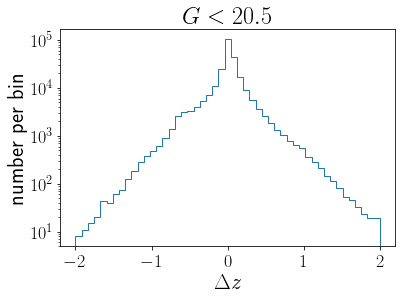

In [23]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(delta_z, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

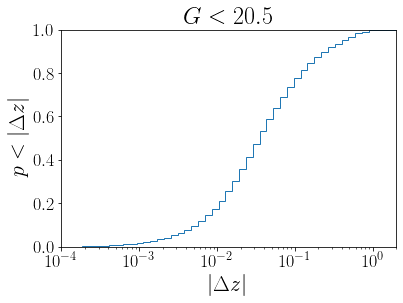

In [24]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(abs(delta_z_G), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, 'number per bin')

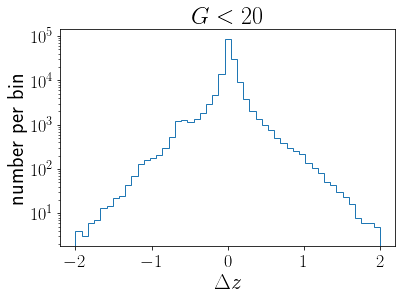

In [25]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(delta_z_G, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

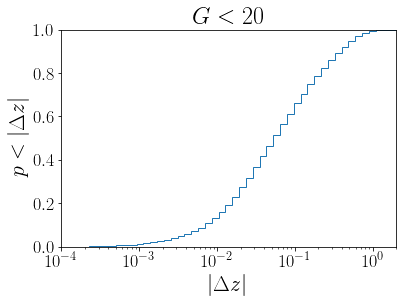

In [26]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(delta_z), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)